<a href="https://colab.research.google.com/github/Bovi-analytics/Hut-et-al-2021/blob/master/RuminatingTime_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for rumination time

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following object is masked from ‘package:ggplot2’:

    vars


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: surviv

## Data loading into dataframe

In [ ]:
%%R
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=RuminationTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-31.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    LactationNumber = factor(TransitionLactationNumber),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    numMonthsInMilk = TransitionMonthsInMilk,
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, numMonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType, LactationNumber) %>%
  tidyr::drop_na()

|===================================================================| 100% 64 MB


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 9
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk numMonthsInMilk
  <fct>            <fct>          <fct>  <fct>                  <int>
1 55               2297           2      6                          6
2 115              2746           1      10                        10
3 115              2746           2      9                          9
4 140              2746           3+     3                          3
5 64               3314           3+     1                          1
6 64               3314           3+     6                          6
# … with 4 more variables: CalvingSeason <fct>, Hour <fct>, SensorValue <dbl>,
#   MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble [417,593 × 9] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1095 levels "1","2","3","4",..: 55 115 115 140 64 64 101 101 101 101 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 4 4 4 6 6 2 2 2 2 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 2 1 2 3 3 3 3 3 1 2 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 6 10 9 3 1 6 7 9 7 1 ...
 $ numMonthsInMilk : int [1:417593] 6 10 9 3 1 6 7 9 7 1 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 2 2 4 1 1 1 1 4 4 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 3 9 2 12 11 11 9 5 5 1 ...
 $ SensorValue     : num [1:417593] 61.7 42.6 57 59.4 46.6 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 1 1 2 2 2 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 417491


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  696
2 2                  686
3 3+                 724


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1067


In [ ]:
%%R
AnalysisData %>%
  group_by(LactationNumber) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 13 x 2
   LactationNumber Unique_Elements
   <fct>                     <int>
 1 1                           696
 2 2                           686
 3 3                           602
 4 4                           468
 5 5                           310
 6 6                           178
 7 7                            79
 8 8                            38
 9 9                            19
10 10                           10
11 11                            5
12 12                            2
13 13                            1


In [ ]:
%%R
xtabs(~ MonthsInMilk + Parity, data = AnalysisData)

            Parity
MonthsInMilk     1     2    3+
          1  10403 10580 22712
          2  10720 10583 22102
          3  11031 10672 21610
          4  11101 10536 21266
          5  10895 10562 20763
          6  10763 10539 20139
          7  10725 10528 19559
          8  10644 10523 19251
          9  10574 10370 18892
          10 10765 10240 18545


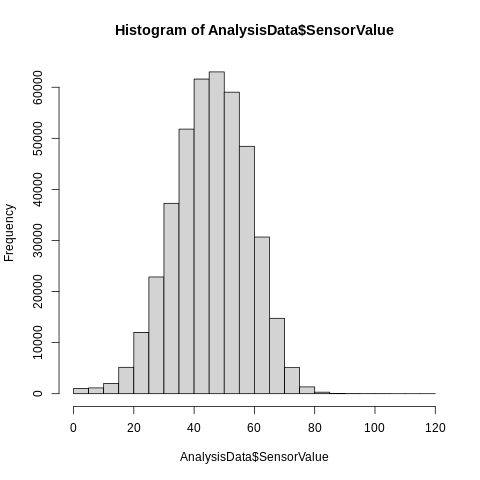

In [ ]:
%%R
hist(AnalysisData$SensorValue)

# Model building

First we determine the null model

### Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1 + numMonthsInMilk|AnimalIdentifier), 
                  data = AnalysisData,
                  REML = FALSE
                  )


### Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.0   14 3262466 3262619 -1631219  3262438 879.41  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.1    7 3263178 3263255 -1631582  3263164 153.38  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.2   12 3255824 3255955 -1627900  3255800 7517.8  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.3    8 3263159 3263247 -1631572  3263143 174.18  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  1 + (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.4: SensorValue ~ Hour + 1 + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.4   16 3056465 3056640 -1528216  3056433 206885 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  1 + (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + 1 + (1 + numMonthsInMilk | AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 3263327 3263382 -1631659  3263317                         
Model1.5    6 3261481 3261547 -1630735  3261469 1848.4  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason +  Hour + MilkingType + HerdIdentifier + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

R[write to console]: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
              npar     AIC    LRT   Pr(Chi)    
<none>             3007761                     
Parity           2 3008208    451 < 2.2e-16 ***
MonthsInMilk     9 3009242   1498 < 2.2e-16 ***
CalvingSeason    3 3007877    121 < 2.2e-16 ***
Hour            11 3235826 228087 < 2.2e-16 ***
MilkingType      1 3007824     65 8.558e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + CalvingSeason + MilkingType + 
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + CalvingSeason + 
Model2.1:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.1   52 3006953 3007522 -1503424  3006849 844.23 18  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.1, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL
 1              44.7 1.45 Inf      41.9      47.6
 2              45.9 1.44 Inf      43.1      48.7
 3              46.3 1.43 Inf      43.5      49.1
 4              46.4 1.42 Inf      43.6      49.2
 5              46.2 1.40 Inf      43.4      48.9
 6              45.8 1.39 Inf      43.0      48.5
 7              45.6 1.38 Inf      42.9      48.3
 8              45.4 1.37 Inf      42.8      48.1
 9              45.3 1.36 Inf      42.7      48.0
 10             45.1 1.35 Inf      42.5      47.8

Results are averaged over the levels of: Parity, Hour, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType + 
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.2:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.2   61 3007235 3007903 -1503557  3007113 580.03 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.2, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL
 1              44.6 0.819 Inf      43.0      46.2
 2              45.9 0.812 Inf      44.3      47.5
 3              46.2 0.805 Inf      44.6      47.8
 4              46.3 0.799 Inf      44.8      47.9
 5              46.0 0.795 Inf      44.5      47.6
 6              45.7 0.791 Inf      44.1      47.2
 7              45.5 0.789 Inf      43.9      47.0
 8              45.4 0.787 Inf      43.8      46.9
 9              45.3 0.787 Inf      43.7      46.8
 10             45.0 0.788 Inf      43.5      46.6

Results are averaged over the levels of: CalvingSeason, Parity, Hour, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.3:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.3   43 3007737 3008208 -1503826  3007651 42.111  9  3.137e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.3, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL
 1              44.4  3.39 Inf     37.74      51.0
 2              45.9  6.73 Inf     32.71      59.1
 3              46.2 10.11 Inf     26.40      66.0
 4              46.3 13.50 Inf     19.83      72.8
 5              46.1 16.90 Inf     12.93      79.2
 6              45.7 20.29 Inf      5.89      85.4
 7              45.5 23.69 Inf     -0.97      91.9
 8              45.3 27.09 Inf     -7.75      98.4
 9              45.2 30.49 Inf    -14.53     105.0
 10             45.0 33.89 Inf    -21.44     111.4

Results are averaged over the levels of: MilkingType, Parity, Hour, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


### Interactions with Hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.4   56 3005652 3006265 -1502770  3005540 2152.9 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.4, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL
 1              44.5  4.72 Inf     35.26      53.8
 2              45.8  7.69 Inf     30.74      60.9
 3              46.1 10.91 Inf     24.76      67.5
 4              46.3 14.21 Inf     18.42      74.1
 5              46.0 17.54 Inf     11.63      80.4
 6              45.6 20.89 Inf      4.69      86.6
 7              45.4 24.25 Inf     -2.10      93.0
 8              45.3 27.62 Inf     -8.81      99.5
 9              45.2 30.99 Inf    -15.55     105.9
 10             44.9 34.37 Inf    -22.42     112.3

Results are averaged over the levels of: Hour, Parity, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.5   45 2999870 3000362 -1499890  2999780 7913.4 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.5, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL
 1              44.6 0.800 Inf      43.0      46.1
 2              45.9 0.793 Inf      44.3      47.4
 3              46.2 0.788 Inf      44.6      47.7
 4              46.3 0.784 Inf      44.8      47.8
 5              46.0 0.780 Inf      44.5      47.6
 6              45.7 0.778 Inf      44.1      47.2
 7              45.5 0.777 Inf      43.9      47.0
 8              45.4 0.777 Inf      43.8      46.9
 9              45.2 0.778 Inf      43.7      46.8
 10             45.0 0.780 Inf      43.4      46.5

Results are averaged over the levels of: Hour, MilkingType, CalvingSeason, Parity 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.6   67 3006926 3007660 -1503396  3006792 900.73 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
lsmeans(Model2.6, ~ MonthsInMilk)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL
 1              44.6 0.818 Inf      43.0      46.2
 2              45.9 0.811 Inf      44.3      47.5
 3              46.2 0.806 Inf      44.6      47.8
 4              46.3 0.801 Inf      44.7      47.9
 5              46.0 0.797 Inf      44.5      47.6
 6              45.7 0.795 Inf      44.1      47.2
 7              45.5 0.794 Inf      43.9      47.0
 8              45.4 0.793 Inf      43.8      46.9
 9              45.2 0.794 Inf      43.7      46.8
 10             45.0 0.796 Inf      43.4      46.5

Results are averaged over the levels of: Hour, CalvingSeason, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*MilkingType + 
                  Hour*Parity + 
                  Hour*CalvingSeason + 
                  Hour*MilkingType +
                  (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * CalvingSeason + 
Model2.7:     MonthsInMilk * MilkingType + Hour * Parity + Hour * CalvingSeason + 
Model2.7:     Hour * MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   34 3007761 3008133 -1503847  3007693                         
Model2.7  154 2995540 2997225 -1497616  2995232 12461 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.8 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*HerdIdentifier +
                  Hour*Parity + 
                  Hour*CalvingSeason + 
                  Hour*HerdIdentifier + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)

In [ ]:
%%R
drop1(Model2.8,test="Chisq")

Single term deletions

Model:
SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * CalvingSeason + 
    MonthsInMilk * HerdIdentifier + Hour * Parity + Hour * CalvingSeason + 
    Hour * HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
                            npar     AIC   LRT   Pr(Chi)    
<none>                           2996794                    
MonthsInMilk:Parity           18 2997784  1026 < 2.2e-16 ***
MonthsInMilk:CalvingSeason    27 2997293   554 < 2.2e-16 ***
MonthsInMilk:HerdIdentifier   63 2997761  1093 < 2.2e-16 ***
Parity:Hour                   22 2998654  1904 < 2.2e-16 ***
CalvingSeason:Hour            33 2997386   658 < 2.2e-16 ***
HerdIdentifier:Hour           77 3037471 40831 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.8

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                  1589.36  9  < 2.2e-16 ***
Parity                         222.49  2  < 2.2e-16 ***
CalvingSeason                  197.73  3  < 2.2e-16 ***
HerdIdentifier               13817.19  7  < 2.2e-16 ***
Hour                        309736.82 11  < 2.2e-16 ***
MonthsInMilk:Parity           1027.55 18  < 2.2e-16 ***
MonthsInMilk:CalvingSeason     554.03 27  < 2.2e-16 ***
MonthsInMilk:HerdIdentifier   1095.53 63  < 2.2e-16 ***
Parity:Hour                   1908.49 22  < 2.2e-16 ***
CalvingSeason:Hour             658.82 33  < 2.2e-16 ***
HerdIdentifier:Hour          42906.55 77  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hoursruminationtime.rdata")

In [ ]:
%%R
load(file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hoursruminationtime.rdata")

In [ ]:
%%R
finalModel

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * CalvingSeason +  
    MonthsInMilk * MilkingType + Hour * Parity + Hour * CalvingSeason +  
    Hour * MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
   Data: AnalysisData
     AIC      BIC   logLik deviance df.resid 
 2995540  2997225 -1497616  2995232   417439 
Random effects:
 Groups                          Name            Std.Dev. Corr 
 AnimalIdentifier:HerdIdentifier (Intercept)     5.84926       
                                 numMonthsInMilk 0.53585  -0.73
 HerdIdentifier                  (Intercept)     1.87993       
                                 numMonthsInMilk 0.07149  -0.16
 Residual                                        8.63270       
Number of obs: 417593, groups:  
AnimalIdentifier:HerdIdentifier, 1706; HerdIdentifier, 8
Fixed Effects:
                       (Intercept)                       MonthsInMilk2  
               

# Final model figures and LSM (95%CI)

## Main effects

In [ ]:
%%R
lsmeans(finalModel, ~ MonthsInMilk)

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="Sidak")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group  
 1              45.4 0.192 Inf      44.8      45.9  a      
 10             45.8 0.163 Inf      45.3      46.2  ab     
 9              46.0 0.156 Inf      45.5      46.4   bc    
 8              46.0 0.151 Inf      45.6      46.4   bc    
 7              46.2 0.149 Inf      45.7      46.6    cd   
 6              46.3 0.150 Inf      45.9      46.7     d   
 2              46.5 0.180 Inf      46.0      47.0     de  
 5              46.7 0.154 Inf      46.3      47.1      ef 
 3              46.9 0.169 Inf      46.4      47.3       fg
 4              47.0 0.160 Inf      46.5      47.4        g

Results are averaged over the levels of: Parity, CalvingSeason, HerdIdentifier, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: sidak method for 45 tests 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       46.0 0.146 Inf      45.6      46.3  a    
 1        46.3 0.148 Inf      45.9      46.6   b   
 2        46.5 0.147 Inf      46.2      46.9    c  

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, HerdIdentifier, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 10     36.4 0.153 Inf      35.9      36.8  a          
 8      37.1 0.153 Inf      36.6      37.5   b         
 18     38.8 0.153 Inf      38.4      39.2    c        
 12     42.2 0.153 Inf      41.7      42.6     d       
 14     43.1 0.153 Inf      42.7      43.6      e      
 16     43.5 0.153 Inf      43.0      43.9       f     
 20     43.6 0.153 Inf      43.2      44.0       f     
 6      47.9 0.153 Inf      47.4      48.3        g    
 22     52.4 0.153 Inf      51.9      52.8         h   
 0      54.0 0.153 Inf      53.6      54.4          i  
 2      56.8 0.153 Inf      56.4      57.3           j 
 4      59.5 0.153 Inf      59.0      59.9            k

Results are averaged over the levels of: MonthsInMilk, Parity, CalvingSeason, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method for comparing a family

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Autumn          45.9 0.148 Inf      45.6      46.3  a    
 Summer          46.2 0.148 Inf      45.8      46.5   b   
 Spring          46.3 0.149 Inf      45.9      46.7   b   
 Winter          46.6 0.149 Inf      46.3      47.0    c  

Results are averaged over the levels of: MonthsInMilk, Parity, HerdIdentifier, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions

### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="Sidak")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.



Parity = 1:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 10     36.7 0.173 Inf      36.2      37.2  a           
 8      37.6 0.173 Inf      37.1      38.1   b          
 18     38.2 0.173 Inf      37.7      38.7    c         
 20     42.2 0.173 Inf      41.7      42.7     d        
 12     42.4 0.173 Inf      41.9      42.9     d        
 14     43.1 0.173 Inf      42.6      43.6      e       
 16     43.5 0.173 Inf      43.0      43.9      e       
 6      47.9 0.173 Inf      47.4      48.4       f      
 22     51.1 0.173 Inf      50.6      51.6        g     
 0      54.2 0.173 Inf      53.7      54.7         h    
 2      57.5 0.173 Inf      57.1      58.0          i   
 4      60.7 0.173 Inf      60.2      61.2           j  

Parity = 2:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 10     36.4 0.172 Inf      35.9      36.8  a           
 8      36.9 0.172 Inf      36.4      37.4   b          
 18     39.0 0.172 Inf      38.5      39.5    c         
 12   

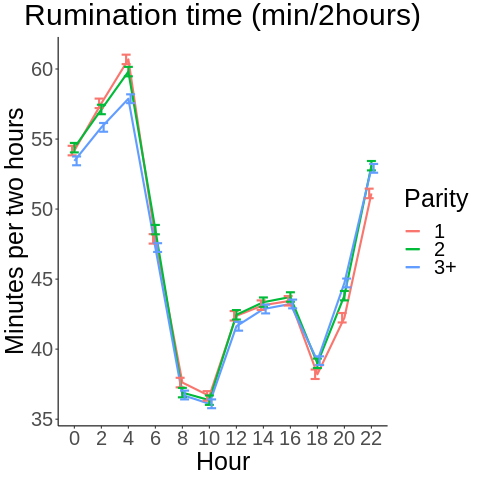

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/RuminationTimeParityBy24h.png", width = 10, height = 8)

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

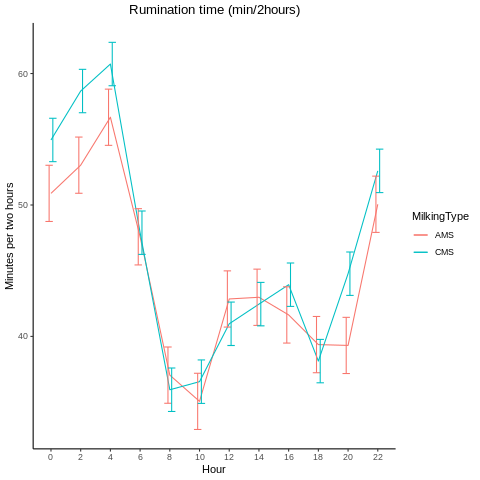

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.5,
    position=position_dodge(0.25)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures/RuminationTimeMilkingTypeBy24h.png", width = 5, height = 4)

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|HerdIdentifier, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



HerdIdentifier = 2011:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 10     31.8 0.206 Inf      31.2      32.4  a          
 8      31.8 0.206 Inf      31.2      32.4  a          
 12     37.3 0.206 Inf      36.7      37.9   b         
 18     38.4 0.206 Inf      37.8      39.0    c        
 20     38.7 0.206 Inf      38.1      39.3    c        
 14     39.8 0.206 Inf      39.2      40.4     d       
 16     41.6 0.206 Inf      41.0      42.2      e      
 22     46.0 0.206 Inf      45.4      46.6       f     
 6      47.4 0.206 Inf      46.8      48.0        g    
 0      49.5 0.206 Inf      48.9      50.0         h   
 2      56.1 0.206 Inf      55.5      56.7          i  
 4      57.6 0.206 Inf      57.0      58.2           j 

HerdIdentifier = 2297:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 8      35.5 0.237 Inf      34.8      36.2  a          
 18     41.8 0.237 Inf      41.1      42.5   b         
 10     42.3 0.237 Inf      41.6      43.0   b         
 

In [ ]:
%%R
dfHerdIdentifier <- data.frame(HerdIdentifier = c("2011", "2297", "2514", "2746", "3", "3314", "544", "5888"),
                 Farm = c("CMS-P", "CMS-P", "AMS-C", "CMS-P", "CMS-P", "AMS-C", "AMS-C", "CMS-P")
                 )

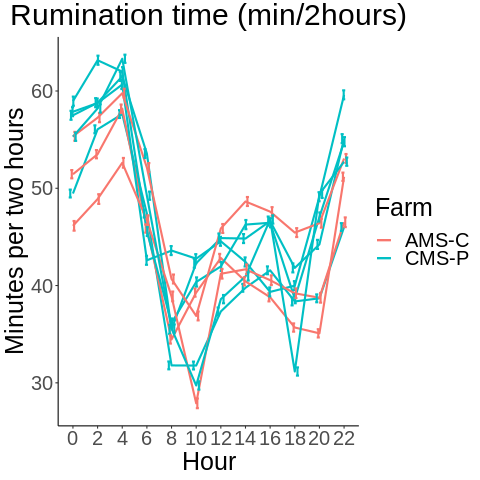

In [ ]:
%%R
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  dplyr::left_join(dfHerdIdentifier, by =  c("HerdIdentifier")) %>%
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(HerdIdentifier), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=HerdIdentifier, 
    color=Farm)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/RuminationTimeMilkingTypeBy24h.png", width = 10, height = 8)

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 10     36.3 0.173 Inf      35.8      36.8  a         
 8      36.6 0.173 Inf      36.1      37.1  a         
 18     38.6 0.173 Inf      38.1      39.1   b        
 12     42.0 0.173 Inf      41.5      42.4    c       
 14     43.1 0.173 Inf      42.6      43.6     d      
 20     43.1 0.173 Inf      42.6      43.6     d      
 16     43.3 0.173 Inf      42.8      43.8     d      
 6      47.4 0.173 Inf      46.9      47.8      e     
 22     52.1 0.173 Inf      51.6      52.6       f    
 0      53.9 0.173 Inf      53.4      54.4        g   
 2      56.3 0.173 Inf      55.8      56.8         h  
 4      58.7 0.173 Inf      58.2      59.2          i 

CalvingSeason = Spring:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 10     36.3 0.177 Inf      35.8      36.8  a         
 8      37.0 0.177 Inf      36.5      37.5   b        
 18     39.3 0.177 Inf      38.8      39.9    c       
 12     42.3 0.1

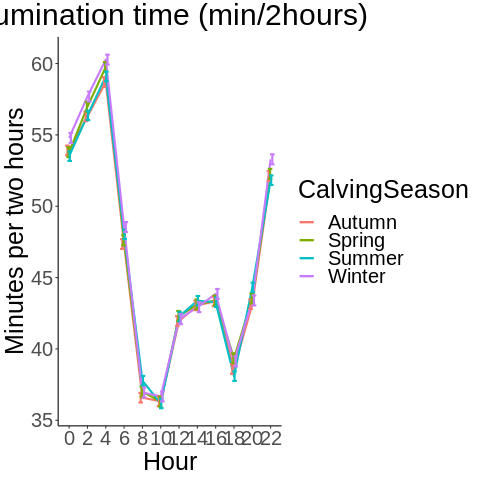

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/RuminationTimeCalvingSeasonBy24h.png", width = 10, height = 8)